# Autoencoders

<a target="_blank" href="https://colab.research.google.com/github/nickplas/Intro_to_ML_24-25/blob/main/notebooks/Lab-13.Autoencoders.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

An autoencoder is a type of neural network architecture that finds the function mapping the features $x$ to itself. This objective is known as reconstruction, and is accomplished through an encoder and a decoder:
* the encoder compresses the input data into a lower-dimensional representation that captures the most important features or patterns;
* the decoder reconstructs the original data from the compressed representation.

The compressed representation learned by an autoencoder can be visualized as a lower-dimensional space, where similar inputs are mapped to nearby points and dissimilar inputs are mapped to distant points. This makes autoencoders useful for tasks such as dimensionality reduction, anomaly detection, and generative modeling.

**NOTE:** *If linear activations are used, or only a single sigmoid hidden layer, then the optimal solution to an autoencoder is strongly related to principal component analysis (PCA). However, the potential of autoencoders resides in their non-linearity, allowing the model to learn more powerful generalizations compared to PCA, and to reconstruct the input with significantly lower information loss.*

In [1]:
# import all needed packages 
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from time import time
import random

# reproducibility
torch.manual_seed(1)
np.random.seed(2)
random.seed(3)

In [2]:
# Avoids jupyter kernel crashes
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# Set arguments
batch_size = 128

# DataLoader Train
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
    transform=torchvision.transforms.ToTensor())

trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True)


# DataLoader Test
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
    transform=torchvision.transforms.ToTensor())

testloader = data.DataLoader(testset, batch_size=16, shuffle=False)

## Training

##### **1. Define the model architecture of an AutoEncoder** 
 As mentioned, it is divided in two parts: encoder and decoder.  
  The encoder takes as input a flattened image of size $28x28$ and applies a series of fully connected layers with Tanh activation function. The output of its last layer has dimension $2$.   
  The decoder takes the 2-dimensional encoded representation and applies a series of fully connected layers with Tanh activation function in the reverse order. The last layer applies a sigmoid activation function to map the reconstructed output to the range $[0,1]$.

In [152]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # BS x 28 x 28 -> BS x 784
        self.encoder_1 = nn.Linear(784,200)
        self.encoder_2 = nn.Linear(200, 50)
        self.encoder_3 = nn.Linear(50, 2)

        self.decoder_1 = nn.Linear(2, 50)
        self.decoder_2 = nn.Linear(50, 200)
        self.decoder_3 = nn.Linear(200, 784)

    def encode(self, x):
        # encode
        x = self.encoder_1(x)
        x = nn.functional.tanh(x)
        x = self.encoder_2(x)
        x = nn.functional.tanh(x)
        x = self.encoder_3(x)
        x = nn.functional.tanh(x)

        return nn.functional.sigmoid(x)

    def decode(self, x):
        x = self.decoder_1(x)
        x = nn.functional.tanh(x)
        x = self.decoder_2(x)
        x = nn.functional.tanh(x)
        x = self.decoder_3(x)
        x = nn.functional.tanh(x)

        return x

    def forward(self, x):
        code = self.encode(x)
        x = self.decode(code)

        return code, nn.functional.sigmoid(x)

In [153]:
def train_model(model, num_epochs, trainloader, criterion, optimizer):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    losses = []
   
    for epoch in range(num_epochs):
        train_running_loss = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in enumerate(trainloader):
            
            # difference here! Similar to .flatten()
            images = images.flatten(start_dim = 1)

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            codes, decoded = model(images)
            loss = criterion(decoded, images)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
        
            
        losses.append(train_running_loss / i)
        
        model.eval()
        print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Time: {time()-start:.2f}") 
    
    return losses

For image data with AutoEncoders it is common to use the mean squared error (MSE) loss function, as it measures the difference between the input image pixels and the reconstructed ones. We are not concerned with labels in this case.

In [ ]:
# Optimizer and loss function
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()
L = train_model(model, 15, trainloader, criterion, optimizer)

In [155]:
L = train_model(model, 15, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 0.1064 | Time: 7.68
Epoch: 2 | Loss: 0.0994 | Time: 7.35
Epoch: 3 | Loss: 0.0978 | Time: 7.82
Epoch: 4 | Loss: 0.0967 | Time: 7.41
Epoch: 5 | Loss: 0.0962 | Time: 7.25
Epoch: 6 | Loss: 0.0957 | Time: 7.64
Epoch: 7 | Loss: 0.0953 | Time: 12.67
Epoch: 8 | Loss: 0.0951 | Time: 7.64
Epoch: 9 | Loss: 0.0948 | Time: 7.97
Epoch: 10 | Loss: 0.0946 | Time: 7.98
Epoch: 11 | Loss: 0.0945 | Time: 7.77
Epoch: 12 | Loss: 0.0943 | Time: 7.23
Epoch: 13 | Loss: 0.0942 | Time: 8.38
Epoch: 14 | Loss: 0.0941 | Time: 8.29
Epoch: 15 | Loss: 0.0939 | Time: 7.18


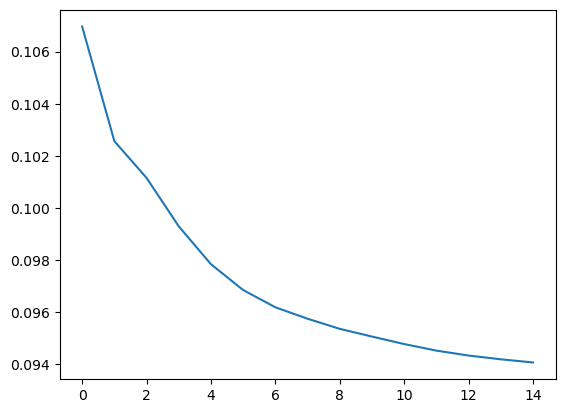

In [138]:
plt.plot(L)
plt.show()

## Extra:
take a random sample in $[-1,1]^{2}$ and decode it. plot it, see what happens???

In [156]:
with torch.no_grad():
    sample = [1.0, 1.0]
    sample = torch.tensor(sample).to(device)
    model.eval()
    out = model.decode(sample)
    out = out.reshape(28, 28)

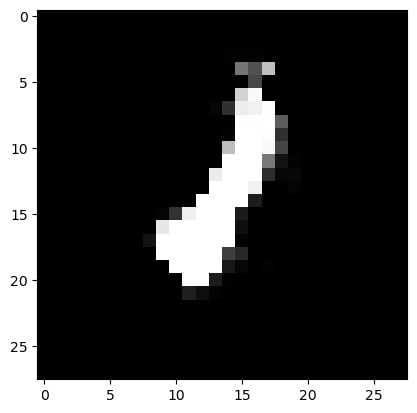

In [157]:
plt.imshow(out.cpu(), cmap='grey')

## Test effects
Now that we have trained the AutoEncoder model, let’s take a look at the picture we restored from the compression. Does it look like the original picture?

In [158]:
# Show images function
def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))

    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.axis('off')

Originals


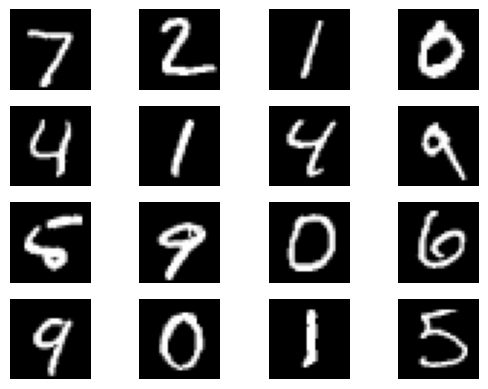

Produced by AutoEncoder


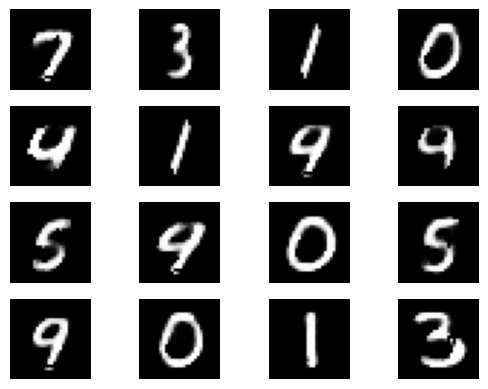

In [159]:
model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Test
with torch.no_grad():
    for images, _ in testloader:
        print("Originals")
        inputs = images.view(-1, 28*28)
        show_images(inputs)
        plt.show()

        print("Produced by AutoEncoder")
        inputs = inputs.to(device)
        code, outputs = model(inputs)
        show_images(outputs.cpu())
        plt.show()
        break

## Visualise compressed data
Earlier, we set the dimension of the output of the encoder to $2$. These two values can be thought of as the $x$ and $y$ coordinates of a point in a two-dimensional space that represents a compressed version of the input image.  
Let's generate a scatter plot of these encoded representations of the images in the test set.


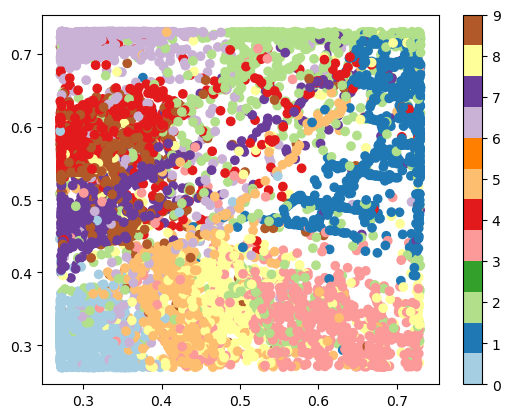

In [160]:
axis_x = []
axis_y = []
answers = []

# turn off gradient calculation to speed up the process
with torch.no_grad():
    for images, labels in testloader:
        inputs = images.view(-1, 28*28)
        answers += labels.tolist()

        inputs = inputs.to(device)
        code, outputs = model(inputs)
        code = code.cpu()
        axis_x += code[:, 0].tolist()
        axis_y += code[:, 1].tolist()


plt.scatter(axis_x, axis_y, c=answers, cmap='Paired')
plt.colorbar()
plt.show()

The data compressed by the Autoencoder has been able to grasp the existence of different features in each number.

## One step further: different types of Autoencoders

There are several types of autoencoders, each designed for a specific purpose. Here are some of the most common types:

* **Convolutional autoencoder**: This type of autoencoder is specifically designed for image data. It uses convolutional layers in the encoder and decoder to take advantage of the spatial structure in the data.
* **Recurrent autoencoder**: This type of autoencoder is designed for sequential data, such as time series or text. It uses recurrent neural networks (RNNs) in the encoder and decoder to capture the temporal dependencies in the data.
* **Denoising autoencoder**: This type of autoencoder is designed to remove noise from input data. During training, the model is fed noisy input data and is trained to reconstruct the original, noise-free input.
* **Variational autoencoder** (VAE): This type of autoencoder is designed to generate new data samples that are similar to the original input data. It uses a probabilistic approach to generate data by sampling from a learned distribution.

##### **2. Create a convolutional autoencoder and use it on MNIST. See how the reconstructed images change and how the encoded representations are scattered in a plane.**

Its decoder uses transposed convolutional layers to increase the width and height of the input layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a $3x3$ kernel, a $3x3$ patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a $3x3$ path in a transposed convolution layer. PyTorch provides us with an easy way to create these layers, [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).

In [188]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # BS x 28 x 28 -> BS x 13 x 13 x 3 
        self.encoder_1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=4, stride=2)

        # BS x 13 x 13 x 3 -> BS x 6 x 6 x 6
        self.encoder_2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=2)

        # BS x 6 x 6 x 6 -> BS x 216 (flatten)
        
        # BS x 216 -> BS x 12
        self.encoder_3 = nn.Linear(216, 2)

        # same but reverse
        self.decoder_1 = nn.Linear(2, 216)

        # reshape to BS x 6 x 6 x 6
        self.decoder_2 = nn.ConvTranspose2d(in_channels=6, out_channels=3, kernel_size=3, stride=2)

        self.decoder_3 = nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=4, stride=2)


    def encode(self, x):
        # encode
        x = self.encoder_1(x)
        x = self.encoder_2(x)

        x = x.flatten(start_dim = 1)

        x = self.encoder_3(x)
        x = nn.functional.tanh(x)

        return x

    def decode(self, x):
        x = self.decoder_1(x)
        x = nn.functional.tanh(x)

        x = x.reshape((-1, 6,6,6))
        x = self.decoder_2(x)
        x = self.decoder_3(x)

        return x

    def forward(self, x):
        code = self.encode(x)
        x = self.decode(code)

        return code, nn.functional.sigmoid(x)

In [189]:
convautoencoder = ConvAutoEncoder()

In [190]:
def train_model_conv(model, num_epochs, trainloader, criterion, optimizer):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    losses = []
   
    for epoch in range(num_epochs):
        train_running_loss = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in enumerate(trainloader):
            
            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            codes, decoded = model(images)
            loss = criterion(decoded, images)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
        
            
        losses.append(train_running_loss / i)
        
        model.eval()
        print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Time: {time()-start:.2f}") 
    
    return losses

In [193]:
# Optimizer and loss function
optimizer = torch.optim.Adam(convautoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()
L = train_model_conv(convautoencoder, 15, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 0.0675 | Time: 7.42
Epoch: 2 | Loss: 0.0675 | Time: 7.29
Epoch: 3 | Loss: 0.0675 | Time: 7.39
Epoch: 4 | Loss: 0.0675 | Time: 7.56
Epoch: 5 | Loss: 0.0675 | Time: 7.49
Epoch: 6 | Loss: 0.0675 | Time: 7.68
Epoch: 7 | Loss: 0.0675 | Time: 7.65
Epoch: 8 | Loss: 0.0675 | Time: 7.84
Epoch: 9 | Loss: 0.0675 | Time: 7.64
Epoch: 10 | Loss: 0.0675 | Time: 7.44
Epoch: 11 | Loss: 0.0675 | Time: 8.05
Epoch: 12 | Loss: 0.0675 | Time: 8.15
Epoch: 13 | Loss: 0.0675 | Time: 7.95
Epoch: 14 | Loss: 0.0675 | Time: 7.50
Epoch: 15 | Loss: 0.0675 | Time: 7.71


Originals


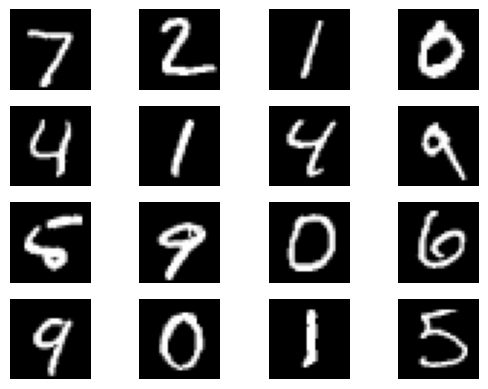

Produced by AutoEncoder


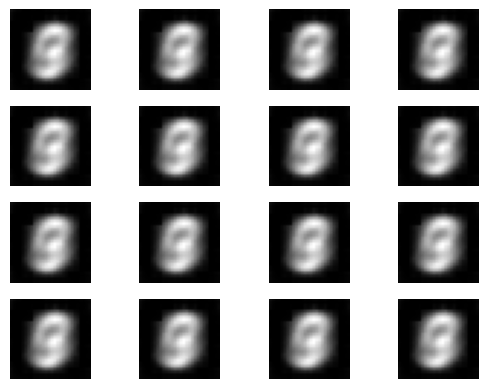

In [194]:
convautoencoder.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Test
with torch.no_grad():
    for images, _ in testloader:
        print("Originals")
        show_images(images)
        plt.show()

        print("Produced by AutoEncoder")
        inputs = images.to(device)
        code, outputs = convautoencoder(inputs)
        show_images(outputs.cpu())
        plt.show()
        break